In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn.preprocessing
import mglearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import Imputer
from missingpy import KNNImputer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
%matplotlib inline

# Preprocessing

In [2]:
mitochondria = pd.read_csv('https://raw.githubusercontent.com/sauchilee/Stat517/master/Data/Mt1t.mutate.csv')
mito = mitochondria.drop([0,1,2], axis=0)
X_mito = mito.drop(['Group'],axis=1)
mito.head()

,Group,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X2702,X2703,X2704,X2705,X2706,X2707,X2708,X2709,X2710,X2711
3,H,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,T,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
5,H,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
6,X,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
7,J,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [3]:
#Uses KNN as imputation method
imputer = KNNImputer(n_neighbors=1)
X_imp = imputer.fit_transform(X_mito)
X_imp = pd.DataFrame(X_imp) #transforms X_imputed from array to pandas dataframe
X_imp.columns = X_mito.columns  #sets column index appropriately

# PCA

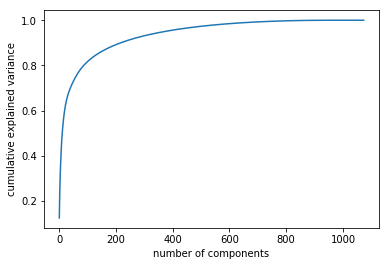

In [4]:
from sklearn.decomposition import PCA
X_mito = X_imp
pca = PCA().fit(X_mito)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

I will use 300 PCs to cover around 90% of the variance.

In [5]:
pca = PCA(n_components=300)
pca.fit(X_mito)
X_pca = pca.transform(X_mito)

# Kmeans Clustering

Text(0,0.5,'S avg')

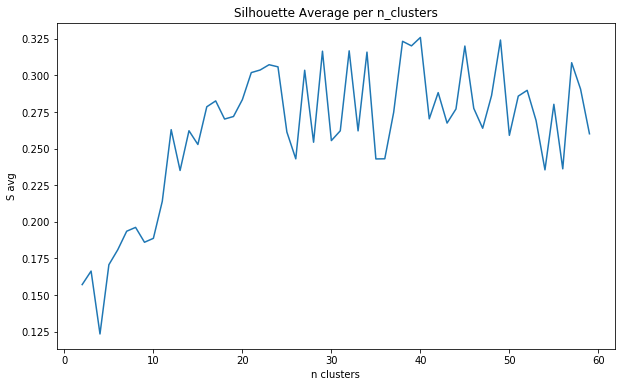

In [6]:
import matplotlib.cm as cm
range_n_clusters = np.arange(2,60,1)
X = X_pca
S = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    S.append(silhouette_avg)
    
plt.figure().set_size_inches(10, 6) 
plt.plot(range_n_clusters,S)
plt.title('Silhouette Average per n_clusters')
plt.xlabel('n clusters')
plt.ylabel('S avg')

In [7]:
for i in range(len(S)):
    if S[i] == max(S):
        n_clust_KM = i+2
        print('Optimal Clusters: ',n_clust_KM)

Optimal Clusters:  40


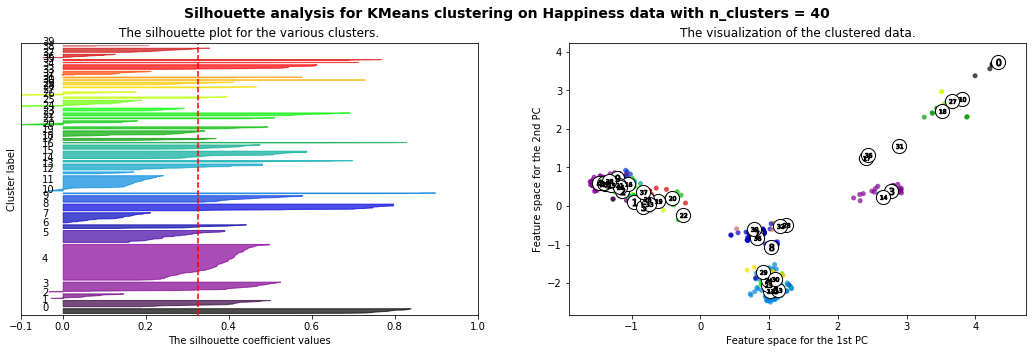

For n_clusters = 40 The average silhouette_score is : 0.3258738486828279


In [8]:
import matplotlib.cm as cm
range_n_clusters = [n_clust_KM]
X = X_pca
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st PC")
    ax2.set_ylabel("Feature space for the 2nd PC")

    plt.suptitle(("Silhouette analysis for KMeans clustering on Happiness data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()
print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

# Heirarchal Clustering

Text(0,0.5,'S avg')

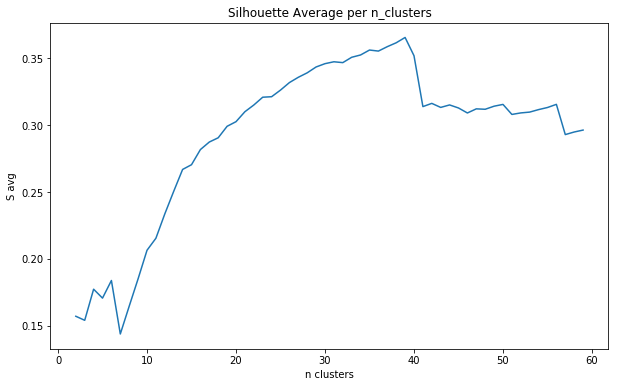

In [9]:
range_n_clusters = np.arange(2,60,1)
X = X_pca
S = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    S.append(silhouette_avg)
    
plt.figure().set_size_inches(10, 6) 
plt.plot(range_n_clusters,S)
plt.title('Silhouette Average per n_clusters')
plt.xlabel('n clusters')
plt.ylabel('S avg')

In [10]:
for i in range(len(S)):
    if S[i] == max(S):
        n_clust_HC = i+2
        print('Optimal Clusters: ',n_clust_HC)

Optimal Clusters:  39


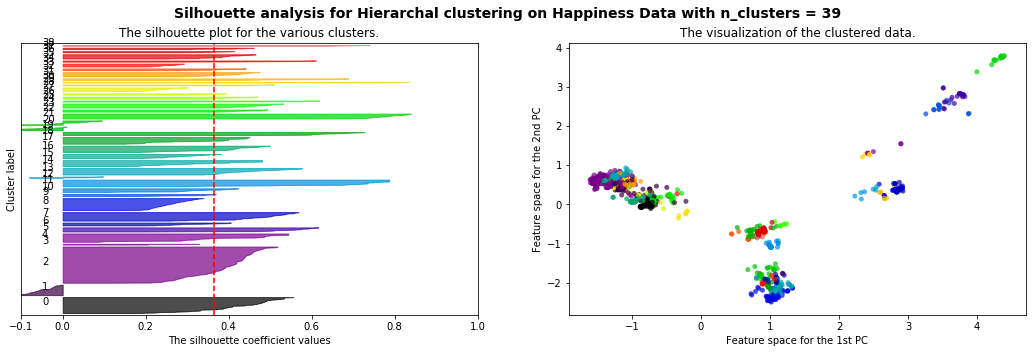

For n_clusters = 39 The average silhouette_score is : 0.3656571597227811


In [11]:
import matplotlib.cm as cm
range_n_clusters = [n_clust_HC]
X = X_pca
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer =  AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st PC")
    ax2.set_ylabel("Feature space for the 2nd PC")
    plt.suptitle(("Silhouette analysis for Hierarchal clustering on Happiness Data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()
print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

# Model Based Clustering: Gaussian Mixture

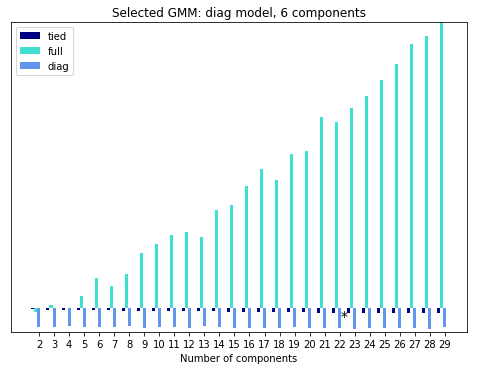

In [12]:
import matplotlib as mpl
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn import mixture

X = X_pca
lowest_bic = np.infty
bic = []
n_components_range = range(2, 30)
cv_types = ['tied', 'full','diag']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(18, 5))
spl = plt.subplot(1, 2, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.xticks(np.arange(2,30,1))
plt.yticks(())
plt.title('Selected GMM: diag model, 6 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

# Cluster Comparisons

Text(0,0.5,'PC2')

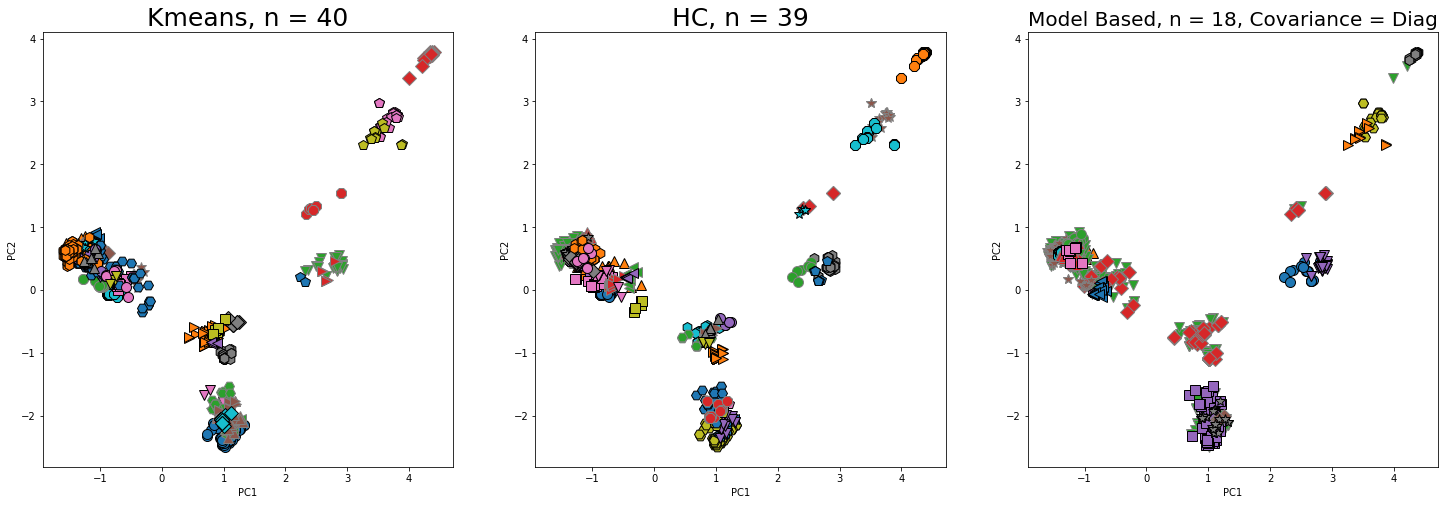

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(25,8))

# Kmeans:
kmeans = KMeans(n_clusters=n_clust_KM)
kmeans.fit(X_pca)
assignments = kmeans.labels_
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], assignments, ax=axes[0])
ax = axes[0]
#ax.legend(["cluster 0", "cluster 1", "cluster 2","cluster 3","cluster 4","cluster 5", "cluster 6", "cluster 7"], loc='upper right')
ax.set_xlabel('PC1')
ax.set_title('Kmeans, n = {:}'.format(n_clust_KM),fontsize = 25)
ax.set_ylabel('PC2')

# Hierarchal:
HC = AgglomerativeClustering(n_clusters=n_clust_HC).fit(X_pca)
assignments = HC.labels_
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], assignments, ax=axes[1])
ax = axes[1]
#ax.legend(["cluster 0", "cluster 1", "cluster 2","cluster 3","cluster 4","cluster 5", "cluster 6", "cluster 7","cluster 8"], loc='upper right')
ax.set_xlabel('PC1')
ax.set_title('HC, n = {:}'.format(n_clust_HC),fontsize = 25)
ax.set_ylabel('PC2')

# Model Based:
gmm = GaussianMixture(n_components=18, covariance_type='diag').fit(X_pca)
assignments =gmm.predict(X_pca)
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], assignments, ax=axes[2])
ax = axes[2]
#ax.legend(["cluster 0", "cluster 1", "cluster 2","cluster 3"], loc='upper right')
ax.set_xlabel('PC1')
ax.set_title('Model Based, n = 18, Covariance = Diag',fontsize = 20)
ax.set_ylabel('PC2')

Now that the models have been fit with an optimal number of clusters, let's look at the groupings of the Haplogroups and Individuals. 

In [14]:
# Append labels to original dataset for analysis
# Make a column for Kmeans labels
mito['ClusterGroupKM'] = kmeans.labels_
# Make a column for GMM labels
mito['ClusterGroupGM'] = gmm.predict(X_pca)
mito.head()

,Group,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X2704,X2705,X2706,X2707,X2708,X2709,X2710,X2711,ClusterGroupKM,ClusterGroupGM
3,H,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1,5
4,T,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,10,2
5,H,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,31,5
6,X,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,20,3
7,J,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,12,5


# Analysis
#### A. Explore and investigate groupings of individuals. How are your groupings of individuals differ from the given mitochondrial haplogroups?
The three tables below shows my 48 groupings of individuals compared to the Haplogroups. In many cases, my groupings correspond to the entirety of the Haplogroups, for example Cluster 0 correctly assigned all 37 of the L3 haplogroup. This is the case for Cluster 2,4,8,11,14,16,26... and many others as can be seen in the table below. Though it did combine two haplogroups in cluster 1, Group H and V. This is most likly due to using kmeans as the clusterer. Kmeans clustering strictly uses distance to cluster data, and does not consider the model or distribution at all. For example, we know that a 0 and 1 matrix more clsoely resembles cosine distance rather than euclidean. 

In [15]:
mito.groupby(['ClusterGroupGM','ClusterGroupKM','Group']).size()

ClusterGroupGM  ClusterGroupKM  Group
0               2               L2         5
                23              L2         9
                30              L2         2
1               15              K         24
2               0               D         28
                1               H          6
                2               L2         1
                3               L1b        2
                5               W         10
                7               L3         8
                8               U          3
                9               A         13
                10              T          3
                11              L3e       22
                                L3h        6
                                Ly         1
                12              J          9
                13              M          4
                14              B         14
                16              N          9
                20              B         28
                 

In [16]:
pd.pivot_table(mito,index=['ClusterGroupGM','ClusterGroupKM','Group'])

X1       X10      X100     X1000  \
ClusterGroupGM ClusterGroupKM Group                                      
0              2              L2     0.0  0.000000  0.000000  0.000000   
               23             L2     0.0  0.000000  0.000000  0.000000   
               30             L2     0.0  0.000000  0.000000  0.000000   
1              15             K      0.0  0.000000  0.000000  0.041667   
2              0              D      0.0  0.000000  0.000000  0.000000   
               1              H      0.0  0.000000  0.000000  0.000000   
               2              L2     0.0  0.000000  0.000000  0.000000   
               3              L1b    0.0  0.000000  0.000000  0.000000   
               5              W      0.0  0.000000  0.000000  0.000000   
               7              L3     0.0  0.000000  0.000000  0.000000   
               8              U      0.0  0.000000  0.000000  0.000000   
               9              A      0.0  0.000000  0.000000  0.000000   
               10             T      0.0  0.000000  0.000000  0.000000   
               11             L3e    0.0  0.000000  0.000000  0.000000   
                              L3h    0.0  0.000000  0.000000  0.000000   
                              Ly     0.0  0.000000  0.000000  0.000000   
               12             J      0.0  0.000000  0.000000  0.000000   
               13             M      0.0  0.000000  0.000000  0.000000   
               14             B      0.0  0.000000  0.000000  0.000000   
               16             N      0.0  0.000000  0.000000  0.000000   
               20             B      0.0  0.000000  0.000000  0.000000   
                              F      0.0  0.000000  0.000000  0.000000   
                              H      0.0  0.000000  0.000000  0.000000   
                              I      0.0  0.000000  0.000000  0.000000   
                              N      0.0  0.000000  0.000000  0.000000   
                              O      0.0  0.000000  0.000000  0.000000   
                              Q      0.0  0.000000  0.000000  0.000000   
                              S      1.0  0.000000  0.000000  0.000000   
                              U      0.0  0.000000  0.000000  0.000000   
                              X      0.0  0.000000  0.000000  0.000000   
...                                  ...       ...       ...       ...   
3              37             F      0.0  0.000000  0.000000  0.000000   
               39             M      0.0  0.000000  0.000000  0.000000   
4              0              D      0.0  0.000000  0.000000  0.000000   
               22             D      0.0  0.000000  0.000000  0.000000   
               26             M      0.0  0.000000  0.000000  0.000000   
               32             M      0.0  0.000000  0.000000  0.000000   
               35             G      0.0  0.000000  0.000000  0.000000   
               39             M      0.0  0.000000  0.000000  0.000000   
5              1              H      0.0  0.000000  0.000000  0.000000   
               12             J      0.0  0.000000  0.000000  0.000000   
               20             B      0.0  0.000000  0.000000  0.000000   
                              R      0.0  0.000000  0.000000  0.000000   
                              V      0.0  0.000000  0.000000  0.000000   
               31             H      0.0  0.008403  0.008403  0.000000   
6              4              A      0.0  0.000000  0.000000  0.000000   
7              3              L1b    0.0  0.000000  0.000000  0.000000   
8              6              L0     0.0  0.000000  0.000000  0.000000   
9              8              U      0.0  0.000000  0.000000  0.000000   
               29             U      0.0  0.000000  0.000000  0.000000   
10             9              A      0.0  0.000000  0.000000  0.000000   
11             18             L1     0.0  0.000000  0.000000  0.000000   
12             10             T      0.0  

In [17]:
# CROSSTAB with Kmeans labels
pd.crosstab(mito['ClusterGroupKM'],mito['Group'],margins=True)

Group,A,B,C,D,F,G,H,I,J,K,...,O,Q,R,S,T,U,V,W,X,All
ClusterGroupKM,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,67,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,67
1,0,0,0,0,0,0,35,0,0,0,...,0,0,0,0,0,0,0,0,0,35
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,52
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12,0,12
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,37
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,37,0,0,0,37


In [18]:
# CROSSTAB with GMM labels
pd.crosstab(mito['ClusterGroupGM'],mito['Group'],margins=True)

Group,A,B,C,D,F,G,H,I,J,K,...,O,Q,R,S,T,U,V,W,X,All
ClusterGroupGM,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
1,0,0,0,0,0,0,0,0,0,24,...,0,0,0,0,0,0,0,0,0,24
2,13,50,6,32,26,8,29,4,13,0,...,2,4,0,1,3,25,0,10,2,297
3,0,2,0,9,3,5,0,2,2,0,...,4,0,0,0,0,0,0,2,5,128
4,0,0,0,47,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,77
5,0,3,0,0,0,0,148,0,20,0,...,0,0,6,0,0,0,13,0,0,190
6,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23


#### B. Explore and investigate groupings of genomic positions where SNP occurrs. How are your groupings of positions relate to the given mitochondrial haplogroups?

The next section explores the relationship between the SNP locations and the cluster groups. To do this I transposed the Mitochondria dataset so that I could evaluate the chromosome locations observations and the Haplogroups as variabls. 

In [19]:
X_mitoT = X_mito.transpose()
X_mitoT.head()
pca = PCA(n_components=200)
pca.fit(X_mitoT)
X_pca_T = pca.transform(X_mitoT)

Text(0,0.5,'S avg')

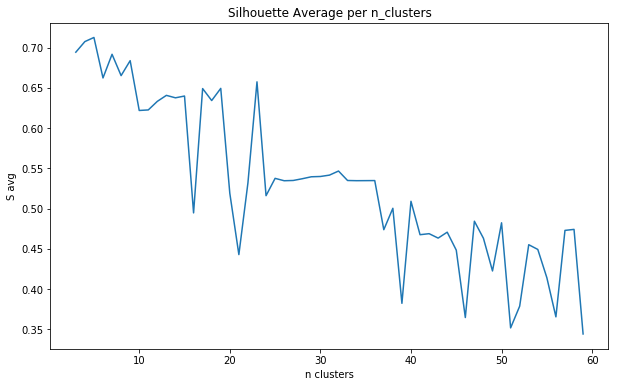

In [20]:
import matplotlib.cm as cm
range_n_clusters = np.arange(3,60,1)
X = X_pca_T
S = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    S.append(silhouette_avg)
    
plt.figure().set_size_inches(10, 6) 
plt.plot(range_n_clusters,S)
plt.title('Silhouette Average per n_clusters')
plt.xlabel('n clusters')
plt.ylabel('S avg')

In [21]:
for i in range(len(S)):
    if S[i] == max(S):
        n_clust_KM = i+2
        print('Optimal Clusters: ',n_clust_KM)

Optimal Clusters:  4


Text(0,0.5,'S avg')

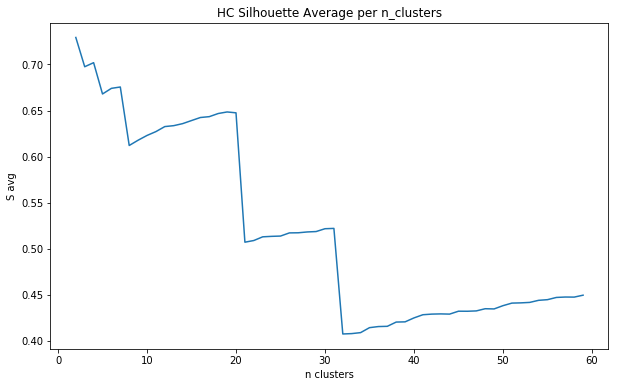

In [22]:
range_n_clusters = np.arange(2,60,1)
X = X_pca_T
S = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    S.append(silhouette_avg)
    
plt.figure().set_size_inches(10, 6) 
plt.plot(range_n_clusters,S)
plt.title('HC Silhouette Average per n_clusters')
plt.xlabel('n clusters')
plt.ylabel('S avg')

In [23]:
for i in range(len(S)):
    if S[i] == max(S):
        n_clust_HC = i+2
        print('Optimal Clusters: ',n_clust_HC)

Optimal Clusters:  2


Text(0,0.5,'PC2')

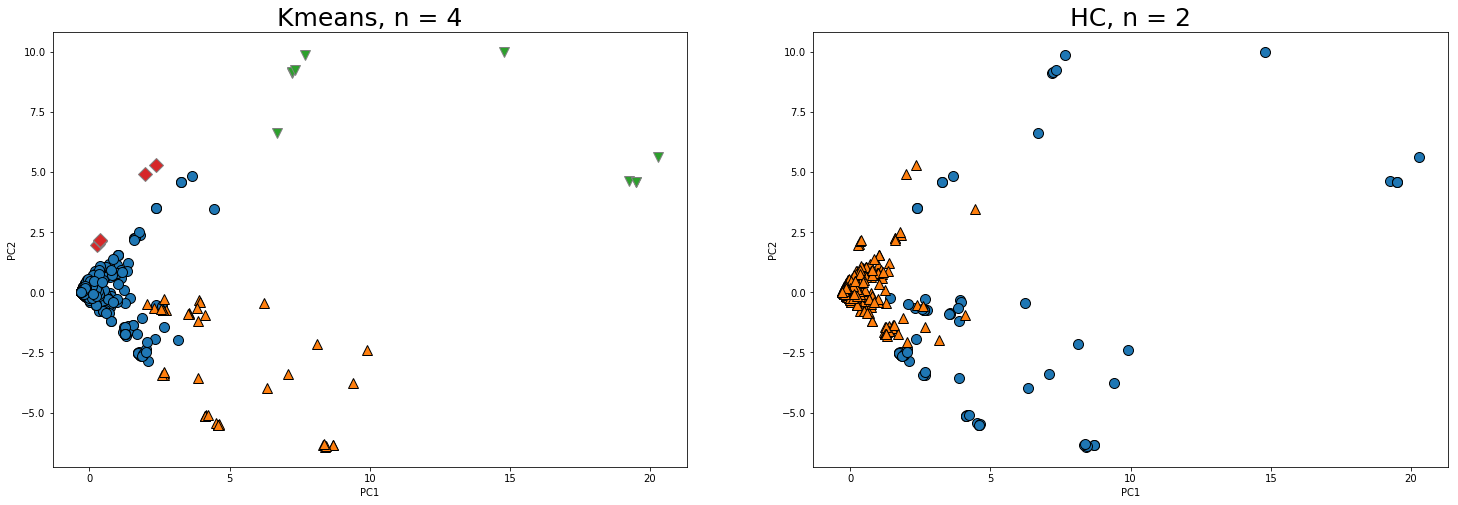

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(25,8))

# Kmeans:
kmeans = KMeans(n_clusters=n_clust_KM)
kmeans.fit(X_pca_T)
assignments = kmeans.labels_
mglearn.discrete_scatter(X_pca_T[:, 0], X_pca_T[:, 1], assignments, ax=axes[0])
ax = axes[0]
#ax.legend(["cluster 0", "cluster 1", "cluster 2","cluster 3","cluster 4","cluster 5", "cluster 6", "cluster 7"], loc='upper right')
ax.set_xlabel('PC1')
ax.set_title('Kmeans, n = {:}'.format(n_clust_KM),fontsize = 25)
ax.set_ylabel('PC2')

# Hierarchal:
HC = AgglomerativeClustering(n_clusters=n_clust_HC).fit(X_pca_T)
assignments = HC.labels_
mglearn.discrete_scatter(X_pca_T[:, 0], X_pca_T[:, 1], assignments, ax=axes[1])
ax = axes[1]
#ax.legend(["cluster 0", "cluster 1", "cluster 2","cluster 3","cluster 4","cluster 5", "cluster 6", "cluster 7","cluster 8"], loc='upper right')
ax.set_xlabel('PC1')
ax.set_title('HC, n = {:}'.format(n_clust_HC),fontsize = 25)
ax.set_ylabel('PC2')

In [25]:
mito_T = X_mito.transpose()
kmeans.fit(X_pca_T)
mito_T['ClusterGroupKM'] = kmeans.labels_
mito_T.head()

,0,1,2,3,4,5,6,7,8,9,...,1065,1066,1067,1068,1069,1070,1071,1072,1073,ClusterGroupKM
X1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
X2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
X3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
X4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
X5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [26]:
pd.crosstab(mito_T['ClusterGroupKM'],mito_T.index,margins=True)

col_0,X1,X10,X100,X1000,X1001,X1002,X1003,X1004,X1005,X1006,...,X991,X992,X993,X994,X995,X996,X997,X998,X999,All
ClusterGroupKM,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,2663
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,32
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
All,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2711


The table above shows how the cluster correspond to the SNP locations. It looks like the dataset was divided into 4 main groups, with the majority of SNPS falling into cluster 0. This could be accurate, as some SNP locations may be more common and more prevalent in the sampled population of patients, while others might be more rare, explaining why some groups only contain a few locations.Furthermore, this analysis was also done using the Kmeans cluster labels whic could introduce some inherene error. For the sake of computation time and memory, the model based clustering was too exhaustive to efficiently use in this project. 